# PREPROCESSING

In [1]:
import cv2
import numpy as np

def preprocess(image):
    image_np = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    image_resized = cv2.resize(image_np, (640, 640))
    return image_resized

In [2]:
import cv2
import numpy as np

def preprocess_for_ocr(image_np):
    # Ubah ke grayscale
    gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)

    # Denoising
    denoised = cv2.fastNlMeansDenoising(gray, h=8)

    # Adaptive threshold
    thresh = cv2.adaptiveThreshold(
        denoised, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY,
        9, 3
    )

    result = cv2.cvtColor(thresh, cv2.COLOR_GRAY2RGB)

    return result

# OBJECT DETECTION MODEL

In [3]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 19.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found exi

In [4]:
from ultralytics import YOLO

model = YOLO("/kaggle/input/fix_model/other/default/1/best.pt")

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [5]:
def process_model(image):
    image_resized = preprocess(image)
    results = model(image_resized)[0]  # Ambil hasil pertama
    boxes = results.boxes  # Bounding box predictions

    bboxes = boxes.xyxy.cpu().numpy()  # [x1, y1, x2, y2]
    classes = boxes.cls.cpu().numpy().astype(int)  # Class index (int)

    # print(f"class: {classes}")
    # print(f"BOX: {bboxes}")
    
    return bboxes, classes

# OCR

In [6]:
!python -m pip install paddlepaddle-gpu==3.0.0 -i https://www.paddlepaddle.org.cn/packages/stable/cu118/
!pip install paddleocr==3.0.0

Looking in indexes: https://www.paddlepaddle.org.cn/packages/stable/cu118/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 GB 1.1 MB/s eta 0:00:0000:0100:04
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 875.6/875.6 kB 8.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 7.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 699.9/699.9 MB 1.9 MB/s eta 0:00:0000:0100:03
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.9/417.9 MB 2.5 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 4.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 MB 6.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 MB 5.3 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.1/204.1 MB 4.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━

In [7]:
from paddleocr import PaddleOCR
ocr = PaddleOCR(use_textline_orientation=True, lang='en')

# image_np = cv2.imread("/kaggle/input/test-image/contoh-1.jpeg")  # Baca sebagai BGR
# image_rgb = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)  # Konversi ke RGB jika perlu
# result = ocr.ocr(image_rgb)

# print(result)

Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/PaddleX3.0/fonts/PingFang-SC-Regular.ttf ...
[==================================================] 100.00%
Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/PaddleX3.0/fonts/simfang.ttf ...
[==================================================] 100.00%


Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-LCNet_x1_0_doc_ori_infer.tar ...
[==================================================] 100.00%
Extracting PP-LCNet_x1_0_doc_ori_infer.tar
[==================================================] 100.00%


/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/UVDoc_infer.tar ...
[==================================================] 100.00%
Extracting UVDoc_infer.tar
[==================================================] 100.00%


Creating model: ('PP-LCNet_x0_25_textline_ori', None)
Using official model (PP-LCNet_x0_25_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-LCNet_x0_25_textline_ori_infer.tar ...
[==================================================] 100.00%
Extracting PP-LCNet_x0_25_textline_ori_infer.tar
[==================================================] 100.00%


Creating model: ('PP-OCRv5_mobile_det', None)
Using official model (PP-OCRv5_mobile_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-OCRv5_mobile_det_infer.tar ...
[==================================================] 100.00%
Extracting PP-OCRv5_mobile_det_infer.tar
[==================================================] 100.00%


Creating model: ('PP-OCRv5_mobile_rec', None)
Using official model (PP-OCRv5_mobile_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-OCRv5_mobile_rec_infer.tar ...
[==================================================] 100.00%
Extracting PP-OCRv5_mobile_rec_infer.tar
[==================================================] 100.00%


In [8]:
label_map = {
    0: 'table',
    1: 'not_table'
}

In [9]:
import re
from typing import List, Dict, Union

def split_detected_text(detected_text: str) -> List[str]:
    """
    Memecah string panjang hasil OCR menjadi list baris berdasarkan pola 'text price'
    Misalnya: "nasi campur 75,ooo ayam 60,ooo" → ["nasi campur 75,ooo", "ayam 60,ooo"]
    """

    # Cari semua potongan yang diakhiri angka (misal 75,000 / 60.000 / 30.0)
    # Asumsikan bahwa item akan memiliki angka di akhir
    pattern = re.compile(r'(.*?\d[\d.,]*)(?=\s+[a-zA-Z]|$)')
    lines = pattern.findall(detected_text)

    # Bersihkan trailing whitespaces
    lines = [line.strip() for line in lines if line.strip()]
    return lines

In [10]:
def extract_multiple_items_from_line(line: str) -> List[Dict[str, Union[str, int]]]:
    """
    Ekstrak pasangan item dan harga dari satu baris teks OCR.
    Menangani multiple item+price dalam satu baris dengan memanfaatkan regex dan heuristik teks sebelumnya.
    """

    # Cari semua harga di baris (format bebas: 3300, 3,300, 3.300, dst)
    matches = list(re.finditer(r'(\d{1,3}(?:[.,]\d{3})+|\d{4,})', line))

    if not matches:
        return []

    items = []
    last_end = 0

    for match in matches:
        price_str = match.group()
        try:
            price = int(price_str.replace(",", "").replace(".", ""))
        except:
            continue

        # Ambil teks sebelum harga sebagai item
        item_text = line[last_end:match.start()].strip()

        # Hindari item kosong atau angka doang
        if item_text and not item_text.replace(" ", "").isdigit():
            items.append({
                "item_name": item_text,
                "price": price
            })

        last_end = match.end()

    return items


def clean_ocr_text(line: str) -> str:
    # Gabungkan angka yang terpisah spasi: "10 0o0" -> "10000"
    line = re.sub(r'(\d)\s+(\d)', r'\1\2', line)

    # Ganti huruf 'o' atau 'O' yang tertulis sebagai nol
    line = line.replace('o', '0').replace('O', '0')

    return line

def detect_class(lines: List[str]) -> List[Dict]:
    processed_results = []

    for line in lines:
        item_price_pairs = extract_multiple_items_from_line(line)
        if item_price_pairs:
            for pair in item_price_pairs:
                processed_results.append({
                    'class': 'item',
                    'text': pair['item_name']  # ← Fix di sini
                })
                processed_results.append({
                    'class': 'price',
                    'price': pair['price']
                })
        else:
            processed_results.append({
                'class': 'item',
                'text': line
            })

    return processed_results

In [11]:
import re
from typing import List, Dict, Union

def reconstruct_items(ner_results: List[Dict]) -> List[Dict]:
    reconstructed = []
    current_item = []
    last_was_item = False
    
    for entry in ner_results:
        if entry['class'] == 'item':
            if not last_was_item and current_item:
                # Jika bertemu item baru, selesaikan item sebelumnya
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            current_item.append(entry['text'])
            last_was_item = True
        else:
            if current_item:
                # Selesaikan item yang sedang dibangun
                reconstructed.append({
                    'class': 'item',
                    'text': ' '.join(current_item).strip(),
                    'original_parts': current_item.copy()
                })
                current_item = []
            reconstructed.append(entry)  # Tambahkan price/entitas lain
            last_was_item = False
    
    # Tambahkan sisa item jika ada
    if current_item:
        reconstructed.append({
            'class': 'item',
            'text': ' '.join(current_item).strip(),
            'original_parts': current_item.copy()
        })
    
    return reconstructed

def pair_entities(ner_results: List[Dict]) -> List[Dict]:
    """Memasangkan item dan price yang berurutan"""
    paired = []
    i = 0
    n = len(ner_results)
    
    while i < n:
        if ner_results[i]['class'] == 'item':
            item = ner_results[i]['text']
            price = None
            numeric_price = None

            # Cari price berikutnya
            if i + 1 < n and ner_results[i+1]['class'] == 'price':
                price_entry = ner_results[i+1]
                price = price_entry.get('price')  # Akses 'price' jika sudah diganti
                numeric_price = price_entry.get('price')  # Atau akses langsung numeric value

                i += 1  # Lewati price yang sudah diproses
            
            paired.append({
                'item_name': item,
                'price': numeric_price
            })
        i += 1
    
    return paired


def is_noise(text: str) -> bool:
    """
    Mengecek apakah suatu teks termasuk 'noise' (bukan item menu, misalnya total, service, dll)
    """
    noise_keywords = [
        'subtotal', 'sub total', 'service', 'tax', 'pajak', 'pb1', 't0tal', 'subt0tal',
        'r0unding','disk0n','disc0unt', 'vc', 'vc pt'
        'rounding', 'diskon', 'discount', 'total', 'grand total', 'change', 'kembalian', 'srand tl'
    ]
    text = text.lower()
    return any(keyword in text for keyword in noise_keywords)


def is_short_or_symbol(text: str, min_length=3) -> bool:
    """Check if text is too short or just symbols/numbers."""
    stripped = text.strip()
    # Skip if:
    # - Length < min_length (default: 3)
    # - Only digits/symbols (e.g., "1", "A", ",M")
    return (
        len(stripped) < min_length or
        stripped.isdigit() or
        (len(stripped) == 1 and not stripped.isalpha())
    )

In [12]:
import re
from typing import List, Dict

def clean_item_name(name: str) -> str:
    # Hapus karakter non-alfanumerik di awal dan akhir (selain huruf dan angka)
    return re.sub(r"^[^\w\d]+|[^\w\d]+$", "", name.strip())

def process_receipt_data_with_ner(ner_results: List[Dict]) -> Dict:
    """Process receipt data with discount handling."""
    reconstructed = reconstruct_items(ner_results)
    paired = pair_entities(reconstructed)
    
    valid_items = []
    discount_keywords = {"uc", "vc", "vc pt", "disc", "voucher", "diskon", "discount"}  # Keywords that indicate discounts
    
    i = 0
    n = len(paired)
    
    while i < n:
        current_item = paired[i]
        
        # Bersihkan item name
        current_item['item_name'] = clean_item_name(current_item['item_name'])
        
        
        # Skip if invalid
        if not current_item['item_name'] or not current_item['price'] or is_noise(current_item['item_name']) or is_short_or_symbol(current_item['item_name']):
            i += 1
            continue
        
        item_name_lower = current_item['item_name'].lower()
        
        # # Check if current item is a discount
        # is_discount = any(keyword in item_name_lower for keyword in discount_keywords)
        
        # if is_discount:
        #     # Apply discount to the previous item (if exists)
        #     if valid_items:
        #         last_item = valid_items[-1]
        #         last_item['price'] -= item['price']  # Subtract discount
        #     i += 1  # Skip adding this as a separate item
        # else:
        #     valid_items.append(item)
        #     i += 1

        # Check if the NEXT item is a discount
        if i + 1 < n:
            next_item = paired[i + 1]
            next_text = next_item['item_name'].lower()
            
            # If next item is a discount, subtract its price
            if any(keyword in next_text for keyword in discount_keywords):
                current_item['price'] -= next_item['price']
                i += 1  # Skip the discount item
                
        valid_items.append(current_item)
        i += 1
    
    return {
        'status': 'success',
        'items': valid_items
    }

In [13]:
import numpy as np
import cv2
import os

# Inisialisasi OCR
keywords = ['total', 'subtotal', 'amount', 'jumlah', 't0tal', 'subt0tal']

def crop_image_by_bbox(image: np.ndarray, bbox: list) -> np.ndarray:
    height, width = image.shape[:2]

    if len(bbox) == 4:
        x_min, y_min, x_max, y_max = bbox
        x_min = int(max(0, min(x_min, width - 1)))
        x_max = int(max(0, min(x_max, width - 1)))
        y_min = int(max(0, min(y_min, height - 1)))
        y_max = int(max(0, min(y_max, height - 1)))

        cropped_image = image[y_min:y_max, x_min:x_max]
        return cropped_image

    elif len(bbox) == 8:
        pts = np.array(bbox, dtype=np.float32).reshape(-1, 2)
        dst_pts = np.array([[0, 0], [639, 0], [639, 639], [0, 639]], dtype=np.float32)
        matrix = cv2.getPerspectiveTransform(pts, dst_pts)
        cropped_image = cv2.warpPerspective(image, matrix, (640, 640))
        return cropped_image

    else:
        raise ValueError("Format bbox tidak valid.")

def read_image(image):
    preprocessed = preprocess(image)
    boxes, classes = process_model(preprocessed)

    print("Langsung cek keyword dari OCR global...")

    preprocessed_ocr = preprocess_for_ocr(preprocessed)

    # Gunakan OCR global
    ocr_result = ocr.predict(preprocessed_ocr)
    
    # If ocr_result is a list containing one dict
    if isinstance(ocr_result, list) and len(ocr_result) > 0:
        ocr_result = ocr_result[0]
    
    # Now access rec_texts
    detected_lines = ocr_result['rec_texts']
    # print(f"detected_lines: {detected_lines}")
    detected_text_lower = " ".join([t.lower() for t in detected_lines if t.strip()])
    print(f"detected_text_lower: {detected_text_lower}")
    
    if any(keyword in detected_text_lower for keyword in keywords):
        print("Keyword ditemukan. Proses ekstraksi data receipt...")

        # OCR berdasarkan bbox dari hasil deteksi model
        detected_lines = []

        for idx, bbox in enumerate(boxes):
            try:
                cropped_image = crop_image_by_bbox(preprocessed_ocr, bbox)
                ocr_result = ocr.predict(cropped_image)
                if ocr_result and isinstance(ocr_result, list) and len(ocr_result) > 0:
                    ocr_result = ocr_result[0]  # Get the first (and usually only) result dict
                    
                    # Extract text line by line
                    for text in ocr_result['rec_texts']:
                        if text.strip():  # Skip empty lines
                            detected_lines.append(text)  # Append the recognized text
                
                    # (Optional) Get bounding boxes for each line (if needed)
                    # line_bboxes = ocr_result['dt_polys']  # List of bounding boxes (if required)

            except ValueError as e:
                print(f"Error dalam cropping gambar: {e}")
                continue

        detected_text_lower = " ".join([t.lower() for t in detected_lines])
        print(detected_text_lower)

        lines = split_detected_text(detected_text_lower)
        ner_results = detect_class(lines)
        final_result = process_receipt_data_with_ner(ner_results)

        print("SPLIT lines:", lines)
        print("NER results:", ner_results)
        print("FINAL:", final_result)

        return final_result

    print("Tidak ada keyword penting ditemukan. Gambar bukan receipt/invoice.")
    return {
        "status": "not_receipt_invoice",
        "error_msg": "Gambar yang Anda masukkan bukan receipt/invoice."
    }


# TEST

In [14]:
def crop_and_save(image, boxes, output_folder="cropped_images", prefix="img"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for idx, bbox in enumerate(boxes):
        try:
            save_path = os.path.join(output_folder, f"{prefix}_crop_{idx}.jpg")
            crop_image_by_bbox(image, bbox, save_path)
        except ValueError as e:
            print(f"Cropping gagal: {e}")

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_boxes_safe(image, boxes, classes, label_map, save_path='output_with_boxes.jpg'):
    image = preprocess(image)
    preprocessed_ocr = preprocess_for_ocr(image)
    image_vis = preprocessed_ocr.copy()
    height, width = preprocessed_ocr.shape[:2]

    for box, cls_id in zip(boxes, classes):
        cls_name = label_map[int(cls_id)]
        color = (0, 255, 0)
        thickness = 2

        try:
            if len(box) == 4:
                # Box = [x1, y1, x2, y2]
                x1, y1, x2, y2 = map(int, box)
                x1 = max(0, min(x1, width - 1))
                x2 = max(0, min(x2, width - 1))
                y1 = max(0, min(y1, height - 1))
                y2 = max(0, min(y2, height - 1))
                cv2.rectangle(image_vis, (x1, y1), (x2, y2), color, thickness)
                cv2.putText(image_vis, cls_name, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

            elif len(box) == 8:
                # Box = quadrilateral [x1, y1, x2, y2, x3, y3, x4, y4]
                pts = np.array(box, dtype=np.int32).reshape(-1, 2)
                pts[:, 0] = np.clip(pts[:, 0], 0, width - 1)
                pts[:, 1] = np.clip(pts[:, 1], 0, height - 1)
                cv2.polylines(image_vis, [pts], isClosed=True, color=color, thickness=2)
                cv2.putText(image_vis, cls_name, tuple(pts[0]), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

        except Exception as e:
            print(f"Gagal menggambar box: {box}, error: {e}")
            continue

    # Simpan dan tampilkan
    cv2.imwrite(save_path, image_vis)
    plt.figure(figsize=(8, 8))
    plt.imshow(cv2.cvtColor(image_vis, cv2.COLOR_BGR2RGB))
    plt.title("Detected BBoxes")
    plt.axis("off")
    plt.show()



--- Gambar ke-1 (contoh-2.jpeg) ---

0: 640x640 (no detections), 8.8ms
Speed: 4.7ms preprocess, 8.8ms inference, 93.5ms postprocess per image at shape (1, 3, 640, 640)


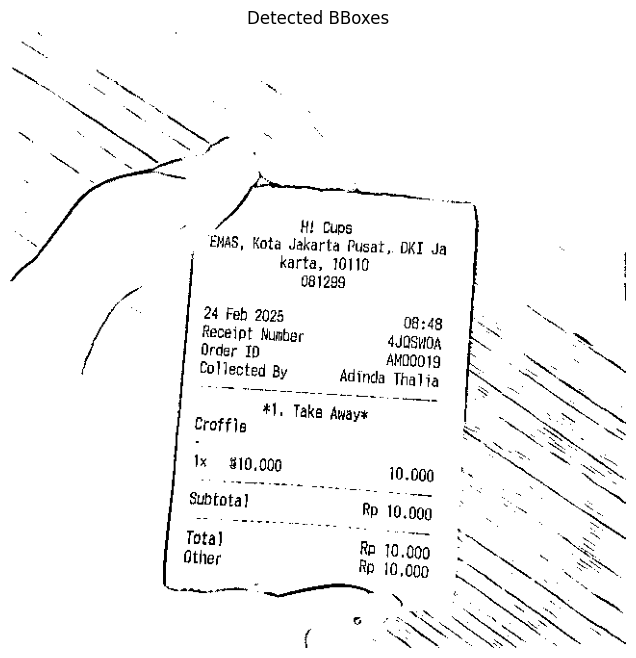


0: 640x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
detected_text_lower: h!cups emas, kota jakarta pusat, dki ja karta, 10110 081299 08:48 24feb2025 4jdshoa receipt number am00019 drderid adinda thalia collected by *1.take away* croffie - 10.000 10.000 ×1 subtotal rp 10.000 total rd10.000 other rp 10.000
Keyword ditemukan. Proses ekstraksi data receipt...

SPLIT lines: []
NER results: []
FINAL: {'status': 'success', 'items': []}

--- Gambar ke-2 (contoh-4.jpeg) ---

0: 640x640 1 table, 7.5ms
Speed: 1.7ms preprocess, 7.5ms inference, 175.6ms postprocess per image at shape (1, 3, 640, 640)


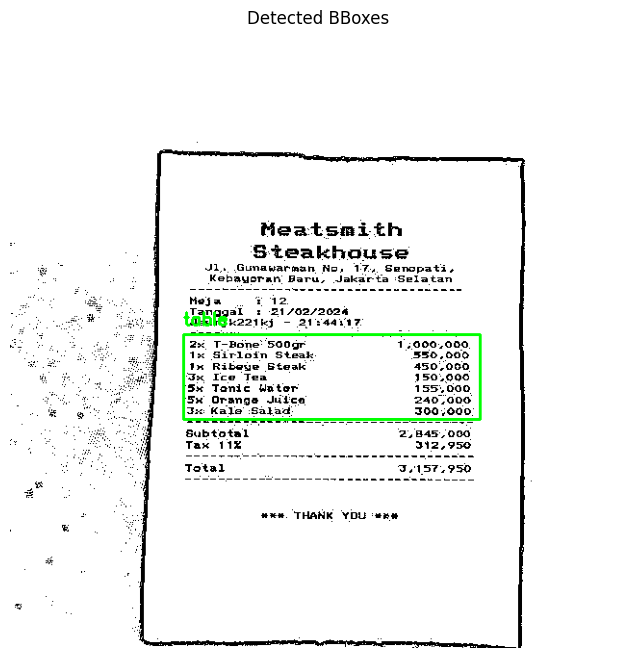


0: 640x640 1 table, 7.4ms
Speed: 1.7ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
detected_text_lower: eatsmith steakhouse 1 12. swnjk221k 2144117. 2 t-bone:'5oogr sirloin steak. 000000 y 000oss 1 ribeuegteak 450.000 i'ce tea 150000 y tanicwator 155.000 orange julca 240.000 c: petesete 000.00m subtotal 2845000 tax11x 312.950 电a1 j157.950 .thankydu
Keyword ditemukan. Proses ekstraksi data receipt...
x2 t-bone 500gr . 000000 x sirlofn steak 550.000 x riboye gteak 450000 xx ice jea 150000 tonic wator juico 155000 k orango 240.000 petes:.te 300:00
SPLIT lines: ['x2', 't-bone 500gr . 000000', 'x sirlofn steak 550.000', 'x riboye gteak 450000', 'xx ice jea 150000', 'tonic wator juico 155000', 'k orango 240.000', 'petes:.te 300:00']
NER results: [{'class': 'item', 'text': 'x2'}, {'class': 'item', 'text': 't-bone 500gr .'}, {'class': 'price', 'price': 0}, {'class': 'item', 'text': 'x sirlofn steak'}, {'class': 'pr

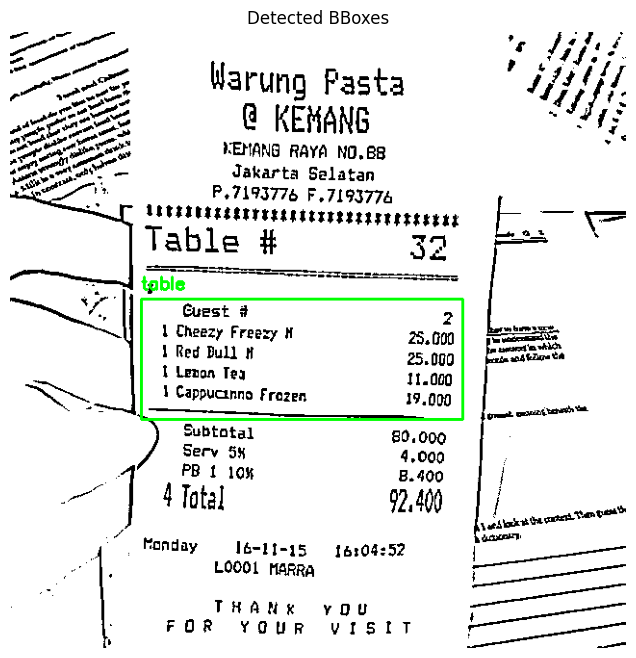


0: 640x640 1 table, 6.3ms
Speed: 1.7ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
detected_text_lower: s n @ kehang emang raya no.bb jakarta selatan p.7193776f.7193776 1*|******************* #bt9e1 2 guest  25.000 25.000 i red bull h 11.000 i lenon tea 19.000 1 cappucinno frozen 80.000 subtotal 4.000 serv 5% b.400 pb 1 10% 92.400 4 total 16-11-15 16:04=52 honday looo1 marra xnuh1 n□a 0 visi1
Keyword ditemukan. Proses ekstraksi data receipt...
guest 4 a h 25.00 red trna h 25.000 gat tea 11.000 i odndes frozen 200*61
SPLIT lines: ['guest 4', 'a h 25.00', 'red trna h 25.000', 'gat tea 11.000', 'i odndes frozen 200*61']
NER results: [{'class': 'item', 'text': 'guest 4'}, {'class': 'item', 'text': 'a h 25.00'}, {'class': 'item', 'text': 'red trna h'}, {'class': 'price', 'price': 25000}, {'class': 'item', 'text': 'gat tea'}, {'class': 'price', 'price': 11000}, {'class': 'item', 'text': 'i odndes frozen 200*61'}]

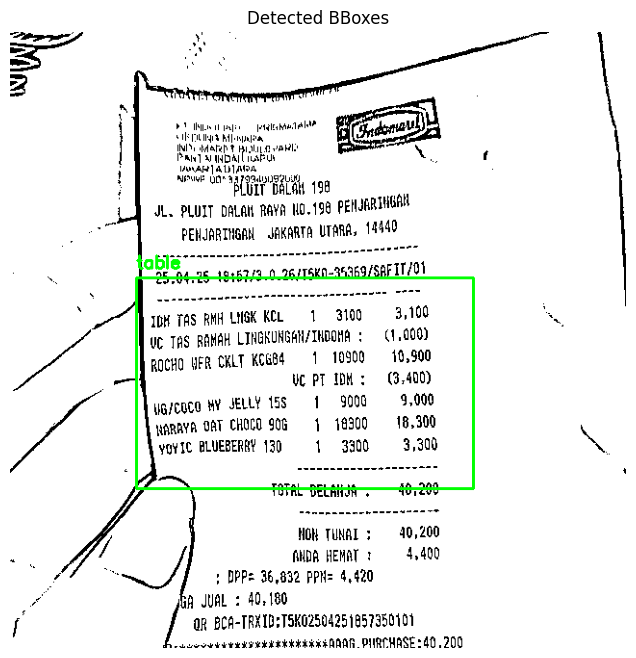


0: 640x640 1 table, 6.3ms
Speed: 1.6ms preprocess, 6.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)
Langsung cek keyword dari OCR global...
detected_text_lower: ，m 11m.11 na11a nimap1. iqn xlai uahau1ma pluit dalah 198 jl、pluit dalan raya ho.19b pehjarihgah pehjarihgan jakarta utara, 14440 25.04.25-18:57/3.0.26/t5k0-35369/safit/01 idh tas rmh liigk kcl 1 3100 3,100 uc tas ramah lingkungah/ihdoma: (1.000) rocho ufr cklt kcgb4 110900 10,900 vc pt idm: (3,400) ug/coco my jelly 15s 1 9000 9,000 arrya oat choco 9og 1 18300 18,300 yoyic blueberry 130 1 3300 3.300 total belahja: 40.200 hohtunai; 40,200 rhdr hemat: 4,400 :dpp=36,832ppn=4.420 ga jual:40.180 qr bca-trxib:t5k02504251857350101
Keyword ditemukan. Proses ekstraksi data receipt...
------------------------------- -- i hoi tas rmh liigk kcl 1 3100 3,100 uc jas ramah lingkungah/ihdoha: (1.000) rocho ufr cklt kcgb4 1 10900 10,900 vc pt : wot (3,400) 03037911 my jelly 15s 1 9000 0006 narrya oat choco 90g 1 18300 18,

In [16]:
import os
from PIL import Image
import numpy as np

# Path ke folder gambar
folder_path = "/kaggle/input/test-image"

# Dapatkan daftar file gambar dengan ekstensi tertentu
image_files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

for i, filename in enumerate(image_files):
    image_path = os.path.join(folder_path, filename)
    try:
        # Buka gambar dan konversi ke array NumPy
        image_pil = Image.open(image_path).convert("RGB")
        image_np = np.array(image_pil)

        print(f"\n--- Gambar ke-{i+1} ({filename}) ---")

        # 1. Model deteksi objek
        boxes, classes = process_model(image_np)

        # 2. Visualisasi (opsional)
        visualize_boxes_safe(image_np, boxes, classes, label_map)

        # 3. OCR
        result = read_image(image_np)
        # print(f"📃 OCR: {result}")

    except Exception as e:
        print(f"❌ Gagal memproses {filename}: {e}")